In [73]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay



sso_data = Path.cwd().parent.parent / "Data/Option_data/sso_new.csv"
parquet_file = (Path.cwd().parent.parent / "Data/Option_data/sso_new")

data_path = Path.cwd().parent.parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2018, 12, 30), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r1 = 7
days_till_exp_r2 = 252
moneyness_min = -2.5
moneyness_max = 2.5



In [2]:
# pl.read_csv(sso_data, separator = ",").estimated_size("mb")

In [74]:
df = pl.scan_csv(sso_data, separator=",")
df.schema
df.fetch(1000)

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,exercise_style
str,str,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,str,i64,str,str
"""2016-01-04""","""2016-01-08""","""C""",1000000,0.0,0.49,0,0,1.692439,0.006994,0.000173,1.300576,-100.3955,109965553,"""AMZN""",0,"""AMAZON.COM INC…","""A"""
"""2016-01-04""","""2016-01-08""","""C""",400000,234.75,238.15,0,0,null,null,null,null,null,109965554,"""AMZN""",0,"""AMAZON.COM INC…","""A"""
"""2016-01-04""","""2016-01-08""","""C""",410000,224.5,228.2,0,0,null,null,null,null,null,109965555,"""AMZN""",0,"""AMAZON.COM INC…","""A"""
"""2016-01-04""","""2016-01-08""","""C""",420000,214.75,218.3,0,0,null,null,null,null,null,109965556,"""AMZN""",0,"""AMAZON.COM INC…","""A"""
"""2016-01-04""","""2016-01-08""","""C""",430000,204.35,208.3,0,0,null,null,null,null,null,109965557,"""AMZN""",0,"""AMAZON.COM INC…","""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2016-01-04""","""2016-02-05""","""C""",702500,11.8,12.45,2,3,0.453501,0.252918,0.003737,60.23388,-155.0522,110256313,"""AMZN""",0,"""AMAZON.COM INC…","""A"""
"""2016-01-04""","""2016-02-05""","""C""",705000,11.25,12.0,20,10,0.453835,0.244734,0.00367,59.17509,-152.4845,110256314,"""AMZN""",0,"""AMAZON.COM INC…","""A"""
"""2016-01-04""","""2016-02-05""","""C""",710000,10.15,10.75,71,62,0.450495,0.22656,0.003543,56.75591,-145.0725,110256315,"""AMZN""",0,"""AMAZON.COM INC…","""A"""


# Lower the data by use of efficiency and formatting

In [75]:
#Desired data types for the columns
int_cols = ["strike_price", "volume", "open_interest"]
float_cols = ["best_bid", "best_offer", "impl_volatility", "delta", "gamma", "vega", "theta"]
datetime_cols = ["date","exdate"]
str_cols = ["cp_flag", "ticker", "exercise_style"]
drop_cols = ["optionid", "index_flag", "issuer", "div_convention", "exercise_style"]

In [76]:
#one line to do all the above
df = df.with_columns(
    [ pl.col(int_cols).cast(pl.Int64),
      pl.col(float_cols).cast(pl.Float64),
      pl.col(datetime_cols).cast(pl.Date),
      pl.col(str_cols).cast(pl.String),
    ]
).drop(drop_cols)

## Apply filter for volume and open interest

In [77]:
# Saving file
data_path_parq = Path.cwd().parent.parent / "Data/Option_data/sso_complete_new.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_path_parq):
    df.sink_parquet(data_path_parq)

# Applying the different filters 
- Time period from 2019 - 2022
- 0 to 7 days experiy
- moneyness from 0.8 to 1.2

In [78]:
df2 = pl.read_parquet(data_path_parq)

dfp = df2.to_pandas()

#Create 1-day before IV
dfp['Prev_day_IV'] = dfp.groupby(['ticker', 'strike_price'])['impl_volatility'].shift(1).fillna(0)

df = pl.from_pandas(dfp)

# #Creating a filter for missing greeks
# df = df.filter((pl.col("delta") > delta_r) | (pl.col("gamma") > gamma_r) | (pl.col("vega") > vega_r) | (pl.col("theta") > theta_r))

# Creating the date filter period
df = df.filter(
    pl.col("exdate").is_between(timeperiod[0], timeperiod[1]),
)
df = df.filter(
    pl.col("date").is_between(timeperiod[0], timeperiod[1]),
)

In [79]:
dfp = df.to_pandas()

# Create a custom business day object that excludes weekends and US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Calculate the number of business days between 'date' and 'exdate'
def business_days_diff(start_date, end_date, business_day_offset):
    return np.busday_count(start_date.date(), end_date.date(), busdaycal=business_day_offset.holidays)

# Get US federal holidays within the range
holidays = USFederalHolidayCalendar().holidays(start=dfp['date'].min(), end=dfp['exdate'].max())

# Convert holidays to numpy datetime64 array
holidays = holidays.to_numpy(dtype='datetime64[D]')

# Calculate the difference in business days for each row
dfp['trading_days_till_exp'] = np.busday_count(dfp['date'].values.astype('datetime64[D]'),
                                               dfp['exdate'].values.astype('datetime64[D]'),
                                               holidays=holidays)


In [80]:
dfp

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,Prev_day_IV,trading_days_till_exp
0,2018-12-31,2019-01-04,C,1000000,489.75,496.45,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.359451,3
1,2018-12-31,2019-01-04,C,1010000,479.75,486.45,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.359058,3
2,2018-12-31,2019-01-04,C,1020000,469.75,476.00,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.358546,3
3,2018-12-31,2019-01-04,C,1030000,459.80,466.50,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.410821,3
4,2018-12-31,2019-01-04,C,1040000,449.80,456.50,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.357189,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13789021,2021-12-31,2021-12-31,P,445000,107.90,108.90,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
13789022,2021-12-31,2021-12-31,P,450000,112.75,114.00,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
13789023,2021-12-31,2021-12-31,P,460000,123.20,123.55,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
13789024,2021-12-31,2021-12-31,P,470000,133.20,133.55,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0


In [81]:
# # Creating the days_till_experire collumn and filter time to maturity
# df = df.with_columns(
#     days_till_exp = pl.col("exdate").cast(pl.Date) - pl.col("date").cast(pl.Date)
# ).sort("cp_flag").sort("date")

# df = df.with_columns(
#     days_till_exp = pl.col("days_till_exp").dt.days()
# )
df = pl.from_pandas(dfp)


df = df.filter(pl.col("trading_days_till_exp") <= days_till_exp_r2)

# #Creating a filter for the volume and open_interest
df = df.filter((pl.col("volume") > volume_r))

# #Create filter for bid higher than ask price
df = df.filter(pl.col("best_bid") <= pl.col("best_offer"))
df = df.filter(pl.col("best_bid") >= bid_price_r)

# Filter out rows where 'impl_volatility' is missing
df = df.filter(pl.col("impl_volatility").is_not_null())

# #Creating a midprices column
# df = df.with_columns(
#     bid_diff = pl.col("best_offer").sub(pl.col("best_bid").cast(pl.Float64)) 
# ).sort("cp_flag").sort("date")

# #Filter for the midprice
# # df = df.filter(pl.col("bid_diff") <= midprice_r)



## Create a graph of the days till expiry and implied volatility of a specific stock for a strike price

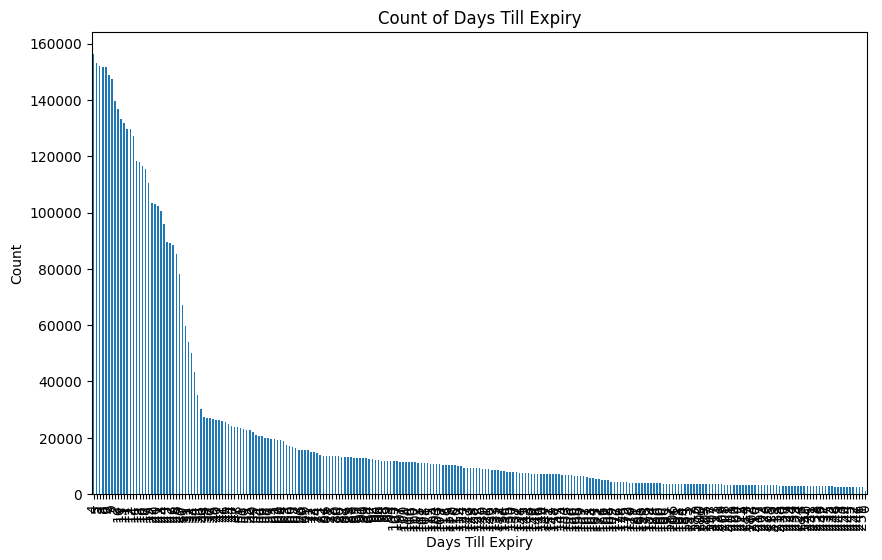

In [82]:
# Get the counts of 'days_till_exp'
df_pandas = df.to_pandas()

counts = df_pandas['trading_days_till_exp'].value_counts()

# Create the bar plot
counts.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Days Till Expiry')
plt.xlabel('Days Till Expiry')
plt.ylabel('Count')
plt.show()

# Merging the stock prices with the options

In [83]:
# Reading the stock data
stock_path_parq = Path.cwd().parent.parent / "Data/Stock_data/stock_data_new.parquet"
df_stock = pl.read_parquet(stock_path_parq)

# Convert Polars dataframes to pandas
df = df.to_pandas()
df_stock = df_stock.to_pandas()

# Ensure that 'date' is a datetime object in both dataframes
df['date'] = pd.to_datetime(df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# Rename the 'TICKER' column in df_stock to 'ticker' to match df
df_stock = df_stock.rename(columns={'TICKER': 'ticker'})

# Merge 'RET' column from df_stock into df
merged_df = pd.merge(df, df_stock[['ticker', 'date', 'PRC', 'PRC_actual']], on=['ticker', 'date'], how='left')


In [84]:
merged_df.sort_values(by='date')

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,Prev_day_IV,trading_days_till_exp,PRC,PRC_actual
0,2018-12-31,2019-01-04,C,1432500,68.60,71.20,7,24,0.178184,0.994818,0.000534,2.352215,-53.92014,AMZN,0.504942,3,1501.96997,75.098499
4468,2018-12-31,2019-01-25,P,122000,3.40,3.65,1,0,0.585733,-0.261992,0.015857,11.337950,-50.90766,NVDA,0.573165,17,133.50000,33.375000
4467,2018-12-31,2019-01-25,P,120000,2.91,3.10,25,370,0.592713,-0.230312,0.014629,10.584350,-47.93344,NVDA,0.577393,17,133.50000,33.375000
4466,2018-12-31,2019-01-25,P,119000,2.69,2.85,15,1,0.596356,-0.215425,0.013998,10.182920,-46.36275,NVDA,0.580655,17,133.50000,33.375000
4465,2018-12-31,2019-01-25,P,118000,2.49,2.65,1,0,0.602069,-0.201803,0.013343,9.800311,-44.97380,NVDA,0.582268,17,133.50000,33.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398535,2021-12-30,2021-12-31,C,3485000,0.78,0.96,469,437,0.345580,0.036080,0.001299,13.995200,-883.31990,AMZN,0.286317,1,NaN,NaN
4398536,2021-12-30,2021-12-31,C,3490000,0.71,0.92,1407,404,0.353829,0.033383,0.001191,13.144620,-848.52950,AMZN,0.292616,1,NaN,NaN
4398537,2021-12-30,2021-12-31,C,3495000,0.68,0.92,512,379,0.364822,0.031980,0.001115,12.690700,-844.46410,AMZN,0.286027,1,NaN,NaN
4398539,2021-12-30,2021-12-31,C,3505000,0.58,0.74,742,505,0.376612,0.026257,0.000917,10.742080,-740.10280,AMZN,0.286238,1,NaN,NaN


## Create the forward price of the stocks

In [85]:
# Load the existing firm and market data
df_firm = merged_df  # Replace with your path
df_macro = pd.read_parquet(Path.cwd().parent.parent / "Data/Macroeconomic_variables/merged_marcofirm.parquet")  # Replace with your path

# Load the dividend data
df_dividends = pd.read_csv(Path.cwd().parent.parent / 'Data/Stock_data/Dividend_Data_2019_2022.csv')  # Replace with your path

# Convert the DATE column to datetime format for easy merging
df_macro['DATE'] = pd.to_datetime(df_macro['DATE'])

# Calculate the annual dividend yield by grouping by ticker and summing the dividends per year
df_dividends['Date'] = pd.to_datetime(df_dividends['Date'])
df_dividends['Year'] = df_dividends['Date'].dt.year
annual_dividends = df_dividends.groupby(['Ticker', 'Year'])['Amount'].sum().reset_index()
annual_dividends['Annual_Dividend_Yield'] = annual_dividends['Amount'] / df_firm['PRC']

# Merge the annual dividend yield back to the firm data
df_firm['Year'] = df_firm['date'].dt.year
df_firm = df_firm.rename(columns={'ticker': 'Ticker'})
df_firm = df_firm.merge(annual_dividends[['Ticker', 'Year', 'Annual_Dividend_Yield']], 
                        on=['Ticker', 'Year'], how='left')

# Fill NaN values in 'Annual_Dividend_Yield' with 0
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].fillna(0)

# Calculate time to maturity in years
df_firm['T'] = df_firm['trading_days_till_exp'] / 252

# Interpolate the 2Y bond rates for exact dates of the firm data
df_firm['DATE'] = df_firm['date']
df_firm = df_firm.merge(df_macro[['DATE', '2Y_bond']], on='DATE', how='left')
df_firm['2Y_bond'].interpolate(method='time', inplace=True)

# Convert '2Y_bond' and 'Annual_Dividend_Yield' to float
df_firm['2Y_bond'] = df_firm['2Y_bond'].astype(float)
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].astype(float)

# Calculate forward prices using the formula F = P * e^(r - q)T
df_firm['Forward_Price'] = df_firm['PRC'] * np.exp(((df_firm['2Y_bond']/100) - df_firm['Annual_Dividend_Yield']) * df_firm['T'])

# Save the updated dataframe with the Forward Price column
# updated_file_path = "/mnt/data/Updated_Firm_Data.csv"
# df_firm.to_csv(updated_file_path, index=False)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/3996837785.py:32: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/3996837785.py:32: FutureWarning:

Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [86]:
df_macro

,DATE,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
0,2018-12-30,2.40,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
1,2018-12-31,2.40,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
2,2019-01-01,2.40,449.000000,0.130000,2.66,2.5342,2.5442,NaN,NaN,NaN,NaN,NaN
3,2019-01-02,2.40,449.354839,0.131290,2.66,2.5342,2.5442,31.46,31.46,22.82,22.82,8.64
4,2019-01-03,2.40,449.709677,0.132581,2.56,2.4762,2.4613,25.82,28.95,24.47,26.59,4.48
...,...,...,...,...,...,...,...,...,...,...,...,...
1094,2021-12-28,0.08,632.632258,-0.209032,1.49,0.4835,0.8040,15.01,15.88,14.39,14.40,1.49
1095,2021-12-29,0.08,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
1096,2021-12-30,0.08,633.116129,-0.204516,1.52,0.4793,0.8076,13.69,14.41,12.98,13.86,1.43
1097,2021-12-31,0.07,633.358065,-0.202258,1.52,0.4764,0.8017,14.24,14.62,13.15,13.26,1.47


In [87]:
df = df_firm


# Function to calculate the ATM IV and add it to the DataFrame
def add_atm_iv(df):
    # Sort DataFrame to ensure correct grouping
    df = df.sort_values(by=['date', 'exdate', 'strike_price'])
    
    # Group by 'date' and 'PRC', here 'PRC' is assumed to be the relevant column for grouping
    grouped = df.groupby(['exdate', 'Forward_Price'])
    
    atm_iv_list = []
    
    # Iterate over each group
    for name, group in grouped:
        # Find the row with the strike price closest to PRC_actual
        group['strike_diff'] = abs((group['strike_price']/1000) - group['Forward_Price'])
        atm_row = group.loc[group['strike_diff'].idxmin()]
        
        # The ATM implied volatility for this group
        atm_iv = atm_row['impl_volatility']
        
        # Assign this ATM IV to all rows in the group
        group['atm_impl_volatility'] = atm_iv
        
        # Append to the list
        atm_iv_list.append(group)
    
    # Concatenate all the groups back into a single DataFrame
    result_df = pd.concat(atm_iv_list)
    
    # Drop the temporary 'strike_diff' column
    result_df = result_df.drop(columns=['strike_diff'])
    
    return result_df

# Applying the function to the DataFrame
df_with_atm_iv = add_atm_iv(df)

print(df_with_atm_iv)

              date     exdate cp_flag  strike_price  best_bid  best_offer  \
1019685 2019-01-03 2019-01-04       P         70000      0.00        0.02   
1019686 2019-01-03 2019-01-04       P         80000      0.00        0.02   
1019687 2019-01-03 2019-01-04       P         83500      0.00        0.02   
1019688 2019-01-03 2019-01-04       P         85000      0.00        0.01   
1019689 2019-01-03 2019-01-04       P         86000      0.00        0.02   
...            ...        ...     ...           ...       ...         ...   
3977180 2021-01-26 2021-12-17       P       3900000    808.60      814.80   
3977135 2021-01-26 2021-12-17       C       4000000    225.00      229.45   
3977136 2021-01-26 2021-12-17       C       4500000    131.10      136.10   
3977137 2021-01-26 2021-12-17       C       4800000     95.30       99.55   
3977138 2021-01-26 2021-12-17       C       5000000     77.45       81.40   

         volume  open_interest  impl_volatility     delta  ...  \
1019685  

In [88]:
df_with_atm_iv.sort_values(by='trading_days_till_exp')

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,trading_days_till_exp,PRC,PRC_actual,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility
1019685,2019-01-03,2019-01-04,P,70000,0.00,0.02,2,55,2.023670,-0.003239,...,1,92.86000,30.953333,2019,0.001438,0.003968,2019-01-03,2.4613,92.868540,0.337398
3167277,2020-02-06,2020-02-07,C,1210000,0.03,0.04,46,59,2.930290,0.001139,...,1,748.96002,49.930668,2020,0.000000,0.003968,2020-02-06,1.4966,749.004501,1.087861
3167278,2020-02-06,2020-02-07,C,1215000,0.01,0.05,46,66,2.917064,0.000991,...,1,748.96002,49.930668,2020,0.000000,0.003968,2020-02-06,1.4966,749.004501,1.087861
3167279,2020-02-06,2020-02-07,C,1220000,0.01,0.07,355,393,3.007757,0.001259,...,1,748.96002,49.930668,2020,0.000000,0.003968,2020-02-06,1.4966,749.004501,1.087861
3167446,2020-02-06,2020-02-07,P,1220000,470.60,473.40,2,7,4.215749,-0.982276,...,1,748.96002,49.930668,2020,0.000000,0.003968,2020-02-06,1.4966,749.004501,1.087861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656102,2020-06-17,2021-06-18,C,210000,16.35,17.75,109,6733,0.307423,0.450330,...,252,194.24001,194.240010,2020,0.001425,1.000000,2020-06-17,0.2351,194.419999,0.321569
2656101,2020-06-17,2021-06-18,C,200000,20.80,21.65,148,3680,0.314348,0.515860,...,252,194.24001,194.240010,2020,0.001425,1.000000,2020-06-17,0.2351,194.419999,0.321569
2656100,2020-06-17,2021-06-18,C,195000,23.10,24.55,28,1477,0.321569,0.549585,...,252,194.24001,194.240010,2020,0.001425,1.000000,2020-06-17,0.2351,194.419999,0.321569
2656107,2020-06-17,2021-06-18,C,260000,4.35,4.85,17,441,0.280326,0.176998,...,252,194.24001,194.240010,2020,0.001425,1.000000,2020-06-17,0.2351,194.419999,0.321569


## Create the moneyness column

In [89]:
merged_df = df_with_atm_iv 

merged_df['moneyness'] = np.log((merged_df['strike_price']/1000) / merged_df['Forward_Price']) / \
                       (np.sqrt(merged_df['T']) * merged_df['atm_impl_volatility'])

# Optionally save the updated DataFrame to a new CSV
# df_firm.to_csv('updated_dataframe_with_moneyness.csv', index=False)

# Print the DataFrame or specific columns to verify the moneyness calculations
print(merged_df[['strike_price', 'Forward_Price', 'T', 'Prev_day_IV', 'moneyness']])

         strike_price  Forward_Price         T  Prev_day_IV  moneyness
1019685         70000      92.868540  0.003968     2.853283 -13.300494
1019686         80000      92.868540  0.003968     1.667637  -7.017868
1019687         83500      92.868540  0.003968     1.266452  -5.003196
1019688         85000      92.868540  0.003968     1.136791  -4.165492
1019689         86000      92.868540  0.003968     1.018112  -3.615196
...               ...            ...       ...          ...        ...
3977180       3900000    3329.820366  0.892857     0.359004   0.460409
3977135       4000000    3329.820366  0.892857     0.354017   0.534158
3977136       4500000    3329.820366  0.892857     0.352593   0.877249
3977137       4800000    3329.820366  0.892857     0.352583   1.065244
3977138       5000000    3329.820366  0.892857     0.353699   1.184154

[4130753 rows x 5 columns]


## Create the trading_day column

In [90]:
# Sort the DataFrame by date
merged_df = merged_df.sort_values('date')

# Create a new column 'trading_day' that ranks each unique date
merged_df['trading_day'] = merged_df['date'].rank(method='dense').astype(int)

# Create a few filters for the dataframe and an overview

In [91]:
#Create moneyness filter
pl_merged = pl.from_pandas(merged_df)

pl_merged = pl_merged.filter((pl.col("moneyness") >= moneyness_min) & (pl.col("moneyness") <= moneyness_max))

pd_merged = pl_merged.to_pandas()


In [92]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,PRC_actual,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day
0,2018-12-31,2019-01-11,C,1580000,14.70,15.15,175,61,0.425357,0.238495,...,75.098499,2018,0.000000,0.031746,2018-12-31,2.5442,1503.183575,0.440226,0.635410,1
1,2018-12-31,2019-01-18,C,360000,6.35,6.50,416,11061,0.551690,0.273087,...,22.186666,2018,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1
2,2018-12-31,2019-01-18,P,360000,34.30,34.75,16,4661,0.551592,-0.723890,...,22.186666,2018,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1
3,2018-12-31,2019-01-18,C,365000,5.10,5.35,241,2051,0.546761,0.234623,...,22.186666,2018,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1
4,2018-12-31,2019-01-18,P,365000,38.05,38.85,22,1056,0.552250,-0.759545,...,22.186666,2018,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408776,2021-01-29,2021-04-16,P,137500,13.45,13.60,224,2799,0.423414,-0.547235,...,131.960010,2021,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.203511,525
3408777,2021-01-29,2021-04-16,C,138750,7.50,7.65,1979,15331,0.432308,0.435965,...,131.960010,2021,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525
3408778,2021-01-29,2021-04-16,P,138750,14.25,14.35,171,751,0.422772,-0.565794,...,131.960010,2021,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525
3408779,2021-01-29,2021-04-16,P,133750,11.25,11.40,578,2169,0.424916,-0.490485,...,131.960010,2021,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.065651,525


In [93]:
df = pd_merged

# Define maturity ranges for tau (τ)
bins = [0, 5, 20, 60, float('inf')]  # upper bounds are exclusive except the last
labels = ['τ≤5', '5<τ≤20', '20<τ≤60', 'τ>60']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define m categories based on delta (adjust as needed)
def classify_m(delta):
    if delta < -0.5:
        return 'm<-0.5'
    elif -0.5 <= delta <= 0.5:
        return '|m|≤0.5'
    else:
        return 'm>0.5'

df['m_category'] = df['moneyness'].apply(classify_m)

# Calculate Number of Contracts (%) and Volume (%)
# Group by maturity group and m category, then calculate counts and volume sums
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number_of_contracts=pd.NamedAgg(column='date', aggfunc='count'),  # Assuming each row is a contract
    Volume=pd.NamedAgg(column='volume', aggfunc='sum')
)

# Calculate percentages
total_contracts = summary['Number_of_contracts'].sum()
total_volume = summary['Volume'].sum()
summary['Number_of_contracts (%)'] = (summary['Number_of_contracts'] / total_contracts) * 100
summary['Volume (%)'] = (summary['Volume'] / total_volume) * 100

# Pivot table with reset index for adding totals
result = summary.pivot_table(index='maturity_group', columns='m_category', 
                             values=['Number_of_contracts (%)', 'Volume (%)'], 
                             fill_value=0).swaplevel(axis=1).sort_index(axis=1)

# Add totals across all columns and rows
result.loc['Total', :] = result.sum()
result['Total'] = result.sum(axis=1)

print(result)

m_category                      m<-0.5                              m>0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           3.076466  12.148169                2.769993   
5<τ≤20                       11.378202   5.983859                9.148344   
20<τ≤60                      10.644333   3.370126                8.551444   
τ>60                         10.967088   1.726190                7.552172   
Total                        36.066089  23.228344               28.021953   

m_category                                |m|≤0.5                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5             16.281841                1.867852  22.527209   58.671531  
5<τ≤20           8.398768                9.851938  12.712773   57.473884  
20<τ≤60 

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/145798476.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/145798476.py:33: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [94]:
result

m_category                      m<-0.5                              m>0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           3.076466  12.148169                2.769993   
5<τ≤20                       11.378202   5.983859                9.148344   
20<τ≤60                      10.644333   3.370126                8.551444   
τ>60                         10.967088   1.726190                7.552172   
Total                        36.066089  23.228344               28.021953   

m_category                                |m|≤0.5                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5             16.281841                1.867852  22.527209   58.671531  
5<τ≤20           8.398768                9.851938  12.712773   57.473884  
20<τ≤60          4.277404               11.484135   6.927711   45.255153  
τ>60             2.019774               12.708033   3.626176   38.599432  
Total           30.977787               35.911958  45.793869  200.000000

In [96]:
df = pd_merged

# Define maturity ranges for tau (τ)
bins = [0, 5, 20, 60, float('inf')]  # upper bounds are exclusive except the last
labels = ['τ≤5', '5<τ≤20', '20<τ≤60', 'τ>60']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define m categories based on moneyness (delta is adjusted to moneyness)
def classify_m(moneyness):
    if moneyness < -0.5:
        return 'm<-0.5'
    elif -0.5 <= moneyness <= 0.5:
        return '|m|≤0.5'
    else:
        return 'm>0.5'

df['m_category'] = df['moneyness'].apply(classify_m)

# Filter data for cp_flag 'P' and 'C'
df_p = df[df['cp_flag'] == 'P']
df_c = df[df['cp_flag'] == 'C']

# Adjusted function to create summary table directly from provided code
def create_summary_table(df):
    # Group by maturity group and m category, then calculate counts and volume sums
    summary = df.groupby(['maturity_group', 'm_category']).agg(
        Number_of_contracts=pd.NamedAgg(column='date', aggfunc='count'),  # Assuming each row is a contract
        Volume=pd.NamedAgg(column='volume', aggfunc='sum')
    )

    # Calculate percentages
    total_contracts = summary['Number_of_contracts'].sum()
    total_volume = summary['Volume'].sum()
    summary['Number_of_contracts (%)'] = (summary['Number_of_contracts'] / total_contracts) * 100
    summary['Volume (%)'] = (summary['Volume'] / total_volume) * 100

    # Pivot table with reset index for adding totals
    result = summary.pivot_table(index='maturity_group', columns='m_category', 
                                 values=['Number_of_contracts (%)', 'Volume (%)'], 
                                 fill_value=0).swaplevel(axis=1).sort_index(axis=1)

    # Add totals across all columns and rows
    result.loc['Total', :] = result.sum()
    result['Total'] = result.sum(axis=1)

    return result

# Create tables for 'P' and 'C'
result_p = create_summary_table(df_p)
result_c = create_summary_table(df_c)

print(result_p)
print(result_c)


m_category                      m<-0.5                              m>0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           3.703193  26.428983                2.314559   
5<τ≤20                       15.326223  13.592262                5.519284   
20<τ≤60                      15.402271   7.845982                3.731963   
τ>60                         15.766396   3.967568                2.442292   
Total                        50.198084  51.834795               14.008097   

m_category                                |m|≤0.5                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5              3.037910                2.003252  22.070343   59.558241  
5<τ≤20           1.156836               10.294706  11.313867   57.203177  
20<τ≤60 

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/688547472.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/688547472.py:38: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/688547472.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/688

In [97]:
result_c

m_category                      m<-0.5                              m>0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           2.529564   4.411077                3.167421   
5<τ≤20                        7.933027   1.861761               12.315183   
20<τ≤60                       6.492396   0.945187               12.757085   
τ>60                          6.779050   0.511852               12.011224   
Total                        23.734037   7.729877               40.250913   

m_category                                |m|≤0.5                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5             23.457168                1.749698  22.774731   58.089658  
5<τ≤20          12.322319                9.465565  13.470675   57.368530  
20<τ≤60          6.310231               11.452420   7.156671   45.113990  
τ>60             2.956288               13.347368   3.822040   39.427822  
Total           45.046007               36.015050  47.224116  200.000000

In [98]:
result_p

m_category                      m<-0.5                              m>0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           3.703193  26.428983                2.314559   
5<τ≤20                       15.326223  13.592262                5.519284   
20<τ≤60                      15.402271   7.845982                3.731963   
τ>60                         15.766396   3.967568                2.442292   
Total                        50.198084  51.834795               14.008097   

m_category                                |m|≤0.5                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5              3.037910                2.003252  22.070343   59.558241  
5<τ≤20           1.156836               10.294706  11.313867   57.203177  
20<τ≤60          0.525292               11.520479   6.505107   45.531094  
τ>60             0.291192               11.975383   3.264658   37.707488  
Total            5.011229               35.793819  43.153976  200.000000

In [104]:
import pandas as pd
import plotly.graph_objects as go

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Use the copy for the filtering
pd_merged_2 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy["m_category"] == "m>0.5") & (pd_merged_copy['cp_flag'] == 'P')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged_2[(pd_merged_2['Ticker'] == 'AMZN') & (pd_merged_2['date'] == date)]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['trading_days_till_exp'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [102]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2018-12-31,2019-01-11,C,1580000,14.70,15.15,175,61,0.425357,0.238495,...,0.000000,0.031746,2018-12-31,2.5442,1503.183575,0.440226,0.635410,1,5<τ≤20,m>0.5
1,2018-12-31,2019-01-18,C,360000,6.35,6.50,416,11061,0.551690,0.273087,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1,5<τ≤20,m>0.5
2,2018-12-31,2019-01-18,P,360000,34.30,34.75,16,4661,0.551592,-0.723890,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1,5<τ≤20,m>0.5
3,2018-12-31,2019-01-18,C,365000,5.10,5.35,241,2051,0.546761,0.234623,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1,5<τ≤20,m>0.5
4,2018-12-31,2019-01-18,P,365000,38.05,38.85,22,1056,0.552250,-0.759545,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1,5<τ≤20,m>0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408776,2021-01-29,2021-04-16,P,137500,13.45,13.60,224,2799,0.423414,-0.547235,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.203511,525,20<τ≤60,|m|≤0.5
3408777,2021-01-29,2021-04-16,C,138750,7.50,7.65,1979,15331,0.432308,0.435965,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525,20<τ≤60,|m|≤0.5
3408778,2021-01-29,2021-04-16,P,138750,14.25,14.35,171,751,0.422772,-0.565794,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525,20<τ≤60,|m|≤0.5
3408779,2021-01-29,2021-04-16,P,133750,11.25,11.40,578,2169,0.424916,-0.490485,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.065651,525,20<τ≤60,|m|≤0.5


In [103]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Use the copy for the filtering
pd_merged_1 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy["m_category"] == "m>0.5") & (pd_merged_copy['cp_flag'] == 'C')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df__nvda = pd_merged_1[(pd_merged_1['Ticker'] == 'AMZN') & (pd_merged_1['date'] == date)]

# Create a grid of x and y values
x = np.linspace(df__nvda['moneyness'].min(), df__nvda['moneyness'].max(), len(df__nvda['moneyness'].unique()))
y = np.linspace(df__nvda['trading_days_till_exp'].min(), df__nvda['trading_days_till_exp'].max(), len(df__nvda['trading_days_till_exp'].unique()))
x_grid, y_grid = np.meshgrid(x, y)

# Interpolate z values
z_grid = griddata((df__nvda['moneyness'], df__nvda['trading_days_till_exp']), df__nvda['impl_volatility'], (x_grid, y_grid), method='cubic')

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis')])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [105]:
pd_merged_1

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2018-12-31,2019-01-11,C,1580000,14.70,15.15,175,61,0.425357,0.238495,...,0.000000,0.031746,2018-12-31,2.5442,1503.183575,0.440226,0.635410,1,5<τ≤20,m>0.5
282,2018-12-31,2019-01-11,C,192500,0.00,0.07,10,55,0.297641,0.011628,...,0.000000,0.031746,2018-12-31,2.5442,171.958842,0.285891,2.215245,1,5<τ≤20,m>0.5
284,2018-12-31,2019-01-11,C,185000,0.15,0.21,42,174,0.276226,0.052920,...,0.000000,0.031746,2018-12-31,2.5442,171.958842,0.285891,1.435080,1,5<τ≤20,m>0.5
286,2018-12-31,2019-01-11,C,182500,0.31,0.36,12,297,0.274720,0.090279,...,0.000000,0.031746,2018-12-31,2.5442,171.958842,0.285891,1.167980,1,5<τ≤20,m>0.5
288,2018-12-31,2019-01-11,C,180000,0.58,0.64,155,1573,0.275256,0.147972,...,0.000000,0.031746,2018-12-31,2.5442,171.958842,0.285891,0.897195,1,5<τ≤20,m>0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408293,2021-01-29,2021-02-05,C,252500,0.32,0.33,975,1776,0.389913,0.061295,...,0.001571,0.019841,2021-01-29,0.1425,231.959337,0.363464,1.657301,525,τ≤5,m>0.5
3408294,2021-01-29,2021-02-05,C,255000,0.25,0.26,1757,6608,0.404481,0.048214,...,0.001571,0.019841,2021-01-29,0.1425,231.959337,0.363464,1.849739,525,τ≤5,m>0.5
3408300,2021-01-29,2021-02-05,C,247500,0.57,0.58,3066,2767,0.365501,0.104688,...,0.001571,0.019841,2021-01-29,0.1425,231.959337,0.363464,1.266642,525,τ≤5,m>0.5
3408320,2021-01-29,2021-02-05,C,257500,0.21,0.22,808,1064,0.423623,0.039963,...,0.001571,0.019841,2021-01-29,0.1425,231.959337,0.363464,2.040300,525,τ≤5,m>0.5


## Plots of the data

In [30]:
# df = pd_merged

# # Define maturity ranges for tau (τ)
# bins = [0, 5, 20, 60, float('inf')]  # upper bounds are exclusive except the last
# labels = ['τ≤5', '5<τ≤20', '20<τ≤60', 'τ>60']
# df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# # Define m categories based on delta (adjust as needed)
# def classify_m(delta):
#     if delta < -2:
#         return 'm<-2'
#     elif -2 <= delta <= -0.5:
#         return '-2≤m<-0.5'
#     elif -0.5 < delta <= 0:
#         return '-0.5<m≤0'
#     elif 0 < delta <= 0.5:
#         return '0<m≤0.5'
#     elif 0.5 < delta <= 2:
#         return '0.5<m≤2'
#     else:
#         return 'm>2'

# df['m_category'] = df['moneyness'].apply(classify_m)

# # Calculate Number of Contracts (%) and Volume (%)
# # Group by maturity group and m category, then calculate counts and volume sums
# summary = df.groupby(['maturity_group', 'm_category']).agg(
#     Number_of_contracts=pd.NamedAgg(column='date', aggfunc='count'),  # Assuming each row is a contract
#     Volume=pd.NamedAgg(column='volume', aggfunc='sum')
# )

# # Calculate percentages
# total_contracts = summary['Number_of_contracts'].sum()
# total_volume = summary['Volume'].sum()
# summary['Number_of_contracts (%)'] = (summary['Number_of_contracts'] / total_contracts) * 100
# summary['Volume (%)'] = (summary['Volume'] / total_volume) * 100

# # Pivot table with reset index for adding totals
# result = summary.pivot_table(index='maturity_group', columns='m_category', 
#                              values=['Number_of_contracts (%)', 'Volume (%)'], 
#                              fill_value=0).swaplevel(axis=1).sort_index(axis=1)

# # Add totals across all columns and rows
# result.loc['Total', :] = result.sum()
# result['Total'] = result.sum(axis=1)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/116368190.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/116368190.py:39: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [31]:
result

m_category                    -0.5<m≤0                          -2≤m<-0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           0.795029   9.733077                2.085745   
5<τ≤20                        4.279531   5.360107                8.197168   
20<τ≤60                       5.034234   2.933449                7.850074   
τ>60                          5.648714   1.528570                8.189892   
Total                        15.757508  19.555203               26.322878   

m_category                                0.5<m≤2             \
               Volume (%) Number_of_contracts (%) Volume (%)   
maturity_group                                                 
τ≤5             10.376676                1.904475  14.065207   
5<τ≤20           5.110184                6.756744   7.355794   
20<τ≤60          2.876317                6.499167   3.756863   
τ>60             1.479735                6.065957   1.802463   
Total           19.842912               21.226342  26.980327   

m_category                     0<m≤0.5                               m<-2  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           0.786016  11.303948                3.051267   
5<τ≤20                        4.059648   6.511711                5.362655   
20<τ≤60                       4.686519   3.535992                3.922007   
τ>60                          5.108008   1.857732                3.295832   
Total                        14.640191  23.209384               15.631761   

m_category                                    m>2                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5              2.980497                1.718562   2.715609   61.516106  
5<τ≤20           1.482420                2.731884   1.207452   58.415298  
20<τ≤60          0.919425                1.507171   0.541443   44.062661  
τ>60             0.436964                0.463703   0.128364   36.005935  
Total            5.819306                6.421320   4.592869  200.000000

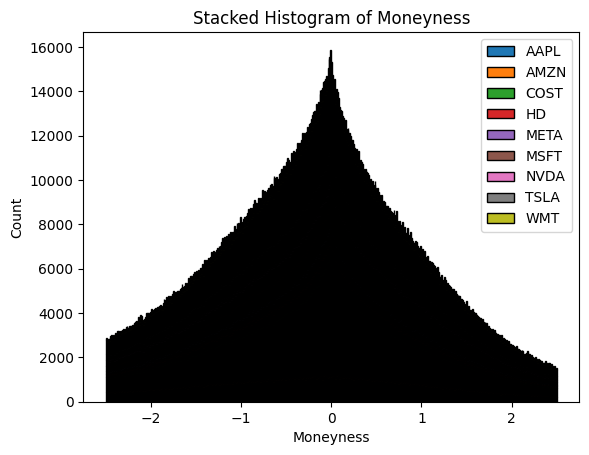

In [106]:
# Group the DataFrame by the 'ticker' column
grouped = pd_merged.groupby('Ticker')

# Create a list of data for each group
data = [group['moneyness'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, bins=500, stacked=True, edgecolor='black', label=labels)

# Set the title and labels
plt.title('Stacked Histogram of Moneyness')
plt.xlabel('Moneyness')
plt.ylabel('Count')

# Set the x-limits
# plt.xlim(0, 2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

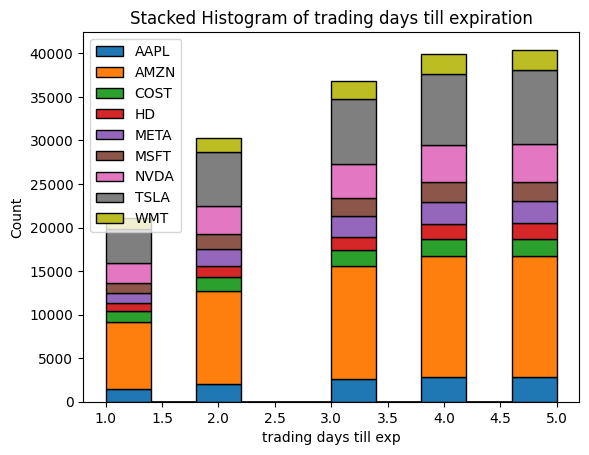

In [107]:
# Create the wished filted
# pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 6) & (pd_merged["m_category"] == "|m| ≤ 2")]
pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 5) & (pd_merged["m_category"] != "|m|<=0.5") & (pd_merged["m_category"] != "m>0.5")]

# Group the DataFrame by the 'ticker' column
grouped = pd_maturity.groupby('Ticker')

# Create a list of data for each group
data = [group['trading_days_till_exp'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, stacked=True, edgecolor='black', label=labels, width=0.4)

# Set the title and labels
plt.title('Stacked Histogram of trading days till expiration')
plt.xlabel('trading days till exp')
plt.ylabel('Count')

# Set the x-limits
# plt.xlim(0, 2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [34]:
# # Filter the DataFrame
# pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 5) & (pd_merged["m_category"] == "|m|≤2.5")]

# # Group the DataFrame by the 'ticker' and 'strike_price' columns and count the number of occurrences
# grouped = pd_maturity.groupby(['Ticker', 'strike_price']).size().reset_index(name='counts')

# # Calculate the average moneyness for each 'Ticker' and 'strike_price'
# average_moneyness = pd_maturity.groupby(['Ticker', 'strike_price'])['moneyness'].mean().reset_index(name='average_moneyness')

# # Calculate the total volume for each 'Ticker' and 'strike_price'
# total_volume = pd_maturity.groupby(['Ticker', 'strike_price'])['volume'].sum().reset_index(name='total_volume')

# # Merge the average moneyness and total volume with the grouped DataFrame
# grouped = pd.merge(grouped, average_moneyness, on=['Ticker', 'strike_price'])
# grouped = pd.merge(grouped, total_volume, on=['Ticker', 'strike_price'])

# # Sort the DataFrame by 'total_volume' in descending order and then group by 'Ticker' to get the top 3 strike prices for each stock
# top_strike_prices = grouped.sort_values('total_volume', ascending=False).groupby('Ticker').head(3)

# # Print the top 3 strike prices for each stock along with the counts, average moneyness, and total volume
# for ticker, group in top_strike_prices.groupby('Ticker'):
#     print(f"Top 3 strike prices for {ticker}:")
#     print(group[['strike_price', 'counts', 'average_moneyness', 'total_volume']])
#     print("\n")

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/357412170.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



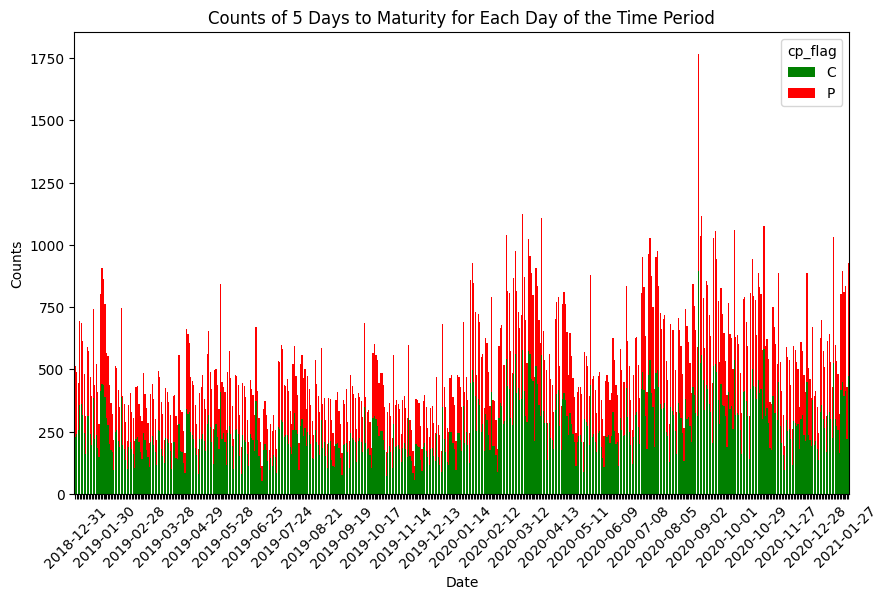

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to only include rows where the trading days till expiration is 6
pd_maturity_6_days = pd_merged[pd_merged["trading_days_till_exp"] <= 5]

# Convert the 'date' column to just date without time
pd_maturity_6_days['date'] = pd.to_datetime(pd_maturity_6_days['date']).dt.date

# Group by the date and 'cp_flag' and count the number of occurrences
counts_by_date = pd_maturity_6_days.groupby(['date', 'cp_flag']).size().unstack(fill_value=0)

# Create a bar plot of the counts by date
ax = counts_by_date.plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(10, 6), width=.8)

plt.title('Counts of 5 Days to Maturity for Each Day of the Time Period')
plt.xlabel('Date')
plt.ylabel('Counts')

# Rotate the x labels and only show every nth label
n = 20  # Show every nth label
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)
    label.set_rotation(45)

plt.show()

In [109]:
#Look at one moneyness specific
filtered_df_c = pd_merged[(pd_merged['trading_days_till_exp'] <= 5) & (pd_merged['moneyness'] >= 0) & (pd_merged['moneyness'] <= 0.5) & (pd_merged['volume'] > 0) & (pd_merged['cp_flag'] == 'C')]

selected_columns = ['Ticker', 'date', 'exdate', 'cp_flag', 'delta', 'impl_volatility', 'Prev_day_IV', 'atm_impl_volatility', 'trading_days_till_exp', 'moneyness']
filtered_df_c = filtered_df_c[selected_columns]
filtered_df_c = filtered_df_c.rename(columns={'trading_days_till_exp': 'tau'})

filtered_df_c.sort_values(by=['Ticker', 'date', 'exdate', 'tau'], inplace=True)

filtered_df_c


,Ticker,date,exdate,cp_flag,delta,impl_volatility,Prev_day_IV,atm_impl_volatility,tau,moneyness
4790,AAPL,2018-12-31,2019-01-04,C,0.332730,0.297505,0.306324,0.289520,3,0.440744
8860,AAPL,2019-01-02,2019-01-04,C,0.311375,0.346461,0.289455,0.348925,2,0.414458
15592,AAPL,2019-01-03,2019-01-04,C,0.427167,0.541977,0.428650,0.560591,1,0.158090
15621,AAPL,2019-01-03,2019-01-04,C,0.327323,0.521244,0.430552,0.560591,1,0.355425
17582,AAPL,2019-01-04,2019-01-11,C,0.460231,0.323932,0.000000,0.330949,5,0.096081
...,...,...,...,...,...,...,...,...,...,...
3394229,WMT,2021-01-28,2021-01-29,C,0.286165,0.288880,0.254439,0.309384,1,0.444272
3394231,WMT,2021-01-28,2021-01-29,C,0.460565,0.309384,0.324496,0.309384,1,0.089184
3407804,WMT,2021-01-29,2021-02-05,C,0.475855,0.315794,0.000000,0.320868,5,0.080189
3407806,WMT,2021-01-29,2021-02-05,C,0.410895,0.312047,0.000000,0.320868,5,0.236552


In [110]:
import pandas as pd
import plotly.graph_objects as go

# Create a copy of pd_merged
filtered_df_c_copy = filtered_df_c.copy()

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Use the copy for the filtering
pd_merged_3 = filtered_df_c_copy[(filtered_df_c_copy["tau"] <= 10) & (filtered_df_c_copy['cp_flag'] == 'C')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged_3[(pd_merged_3['Ticker'] == 'AMZN')]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['tau'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [111]:
filtered_df_c['exdate'] = pd.to_datetime(filtered_df_c['exdate'])
train_data = filtered_df_c[filtered_df_c['exdate'].dt.year <= 2020]
test_data = filtered_df_c[filtered_df_c['exdate'].dt.year == 2021]

In [112]:
train_data

,Ticker,date,exdate,cp_flag,delta,impl_volatility,Prev_day_IV,atm_impl_volatility,tau,moneyness
4790,AAPL,2018-12-31,2019-01-04,C,0.332730,0.297505,0.306324,0.289520,3,0.440744
8860,AAPL,2019-01-02,2019-01-04,C,0.311375,0.346461,0.289455,0.348925,2,0.414458
15592,AAPL,2019-01-03,2019-01-04,C,0.427167,0.541977,0.428650,0.560591,1,0.158090
15621,AAPL,2019-01-03,2019-01-04,C,0.327323,0.521244,0.430552,0.560591,1,0.355425
17582,AAPL,2019-01-04,2019-01-11,C,0.460231,0.323932,0.000000,0.330949,5,0.096081
...,...,...,...,...,...,...,...,...,...,...
3219837,WMT,2020-12-23,2020-12-31,C,0.428650,0.188456,0.085660,0.192365,5,0.200406
3225602,WMT,2020-12-24,2020-12-31,C,0.438924,0.152029,0.000000,0.152029,4,0.181579
3229854,WMT,2020-12-28,2020-12-31,C,0.385852,0.197152,0.211791,0.196374,3,0.249983
3237995,WMT,2020-12-29,2020-12-31,C,0.373338,0.197559,0.251654,0.202318,2,0.268465


In [113]:
from sklearn.metrics import mean_absolute_error

# Group by 'Ticker', 'moneyness' and 'tau', then calculate the mean implied volatility
forecast = train_data.groupby(['Ticker', 'moneyness', 'tau'])['impl_volatility'].mean().reset_index()

# Pivot the table to have 'moneyness' and 'tau' as indices and 'Ticker' as columns
forecast_pivot = forecast.pivot_table(index=['moneyness', 'tau'], columns='Ticker', values='impl_volatility')

# Merge the test data with the forecast
merged = pd.merge(test_data, forecast, on=['Ticker', 'moneyness', 'tau'], how='left', suffixes=('_actual', '_forecast'))

# Calculate the MAE for each ticker, excluding rows with NaN values
mae = merged.dropna(subset=['impl_volatility_actual', 'impl_volatility_forecast']).groupby('Ticker').apply(lambda x: mean_absolute_error(x['impl_volatility_actual'], x['impl_volatility_forecast']))

# Print the ticker with the lowest MAE

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/2415703505.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [114]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2018-12-31,2019-01-11,C,1580000,14.70,15.15,175,61,0.425357,0.238495,...,0.000000,0.031746,2018-12-31,2.5442,1503.183575,0.440226,0.635410,1,5<τ≤20,m>0.5
1,2018-12-31,2019-01-18,C,360000,6.35,6.50,416,11061,0.551690,0.273087,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1,5<τ≤20,m>0.5
2,2018-12-31,2019-01-18,P,360000,34.30,34.75,16,4661,0.551592,-0.723890,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1,5<τ≤20,m>0.5
3,2018-12-31,2019-01-18,C,365000,5.10,5.35,241,2051,0.546761,0.234623,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1,5<τ≤20,m>0.5
4,2018-12-31,2019-01-18,P,365000,38.05,38.85,22,1056,0.552250,-0.759545,...,0.000000,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1,5<τ≤20,m>0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408776,2021-01-29,2021-04-16,P,137500,13.45,13.60,224,2799,0.423414,-0.547235,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.203511,525,20<τ≤60,|m|≤0.5
3408777,2021-01-29,2021-04-16,C,138750,7.50,7.65,1979,15331,0.432308,0.435965,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525,20<τ≤60,|m|≤0.5
3408778,2021-01-29,2021-04-16,P,138750,14.25,14.35,171,751,0.422772,-0.565794,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525,20<τ≤60,|m|≤0.5
3408779,2021-01-29,2021-04-16,P,133750,11.25,11.40,578,2169,0.424916,-0.490485,...,0.000000,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.065651,525,20<τ≤60,|m|≤0.5


In [115]:
# Saving file 
option_data_path_parq = Path.cwd().parent.parent / "Data/all_options_data_new.parquet"

save_parquet = True
if save_parquet or not os.path.exists(option_data_path_parq):
    pd_merged.to_parquet(option_data_path_parq)

## Group the moneyness on every trading day

In [116]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay



sso_data = Path.cwd().parent.parent / "Data/Option_data/sso_new.csv"
parquet_file = (Path.cwd().parent.parent / "Data/Option_data/sso_new")

data_path = Path.cwd().parent.parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2018, 12, 30), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r1 = 7
days_till_exp_r2 = 252
moneyness_min = -2.5
moneyness_max = 2.5



In [117]:
#Read the file
option_data_path_parq = Path.cwd().parent.parent / "Data/all_options_data_new.parquet"

df = pd.read_parquet(option_data_path_parq)

print(df.columns)

df['spread_option'] = df['best_offer'] - df['best_bid']

df

Index(['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer',
       'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega',
       'theta', 'Ticker', 'Prev_day_IV', 'trading_days_till_exp', 'PRC',
       'PRC_actual', 'Year', 'Annual_Dividend_Yield', 'T', 'DATE', '2Y_bond',
       'Forward_Price', 'atm_impl_volatility', 'moneyness', 'trading_day',
       'maturity_group', 'm_category'],
      dtype='object')


,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category,spread_option
0,2018-12-31,2019-01-11,C,1580000,14.70,15.15,175,61,0.425357,0.238495,...,0.031746,2018-12-31,2.5442,1503.183575,0.440226,0.635410,1,5<τ≤20,m>0.5,0.45
1,2018-12-31,2019-01-18,C,360000,6.35,6.50,416,11061,0.551690,0.273087,...,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1,5<τ≤20,m>0.5,0.15
2,2018-12-31,2019-01-18,P,360000,34.30,34.75,16,4661,0.551592,-0.723890,...,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.564015,1,5<τ≤20,m>0.5,0.45
3,2018-12-31,2019-01-18,C,365000,5.10,5.35,241,2051,0.546761,0.234623,...,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1,5<τ≤20,m>0.5,0.25
4,2018-12-31,2019-01-18,P,365000,38.05,38.85,22,1056,0.552250,-0.759545,...,0.051587,2018-12-31,2.5442,333.237071,0.603025,0.664723,1,5<τ≤20,m>0.5,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408776,2021-01-29,2021-04-16,P,137500,13.45,13.60,224,2799,0.423414,-0.547235,...,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.203511,525,20<τ≤60,|m|≤0.5,0.15
3408777,2021-01-29,2021-04-16,C,138750,7.50,7.65,1979,15331,0.432308,0.435965,...,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525,20<τ≤60,|m|≤0.5,0.15
3408778,2021-01-29,2021-04-16,P,138750,14.25,14.35,171,751,0.422772,-0.565794,...,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.248630,525,20<τ≤60,|m|≤0.5,0.10
3408779,2021-01-29,2021-04-16,P,133750,11.25,11.40,578,2169,0.424916,-0.490485,...,0.214286,2021-01-29,0.1425,132.000311,0.433296,0.065651,525,20<τ≤60,|m|≤0.5,0.15


In [118]:
test_df = df[['m_category', 'Ticker', 'maturity_group', 'cp_flag', 'date', 'impl_volatility', 'Prev_day_IV', 'volume', 'open_interest', 'trading_days_till_exp', 'spread_option']]

In [119]:
test_df

,m_category,Ticker,maturity_group,cp_flag,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,spread_option
0,m>0.5,AMZN,5<τ≤20,C,2018-12-31,0.425357,0.633834,175,61,8,0.45
1,m>0.5,TSLA,5<τ≤20,C,2018-12-31,0.551690,0.573377,416,11061,13,0.15
2,m>0.5,TSLA,5<τ≤20,P,2018-12-31,0.551592,0.551690,16,4661,13,0.45
3,m>0.5,TSLA,5<τ≤20,C,2018-12-31,0.546761,0.569921,241,2051,13,0.25
4,m>0.5,TSLA,5<τ≤20,P,2018-12-31,0.552250,0.546761,22,1056,13,0.80
...,...,...,...,...,...,...,...,...,...,...,...
3408776,|m|≤0.5,AAPL,20<τ≤60,P,2021-01-29,0.423414,0.430812,224,2799,54,0.15
3408777,|m|≤0.5,AAPL,20<τ≤60,C,2021-01-29,0.432308,0.407456,1979,15331,54,0.15
3408778,|m|≤0.5,AAPL,20<τ≤60,P,2021-01-29,0.422772,0.432308,171,751,54,0.10
3408779,|m|≤0.5,AAPL,20<τ≤60,P,2021-01-29,0.424916,0.433329,578,2169,54,0.15


In [120]:
print(test_df.columns)

Index(['m_category', 'Ticker', 'maturity_group', 'cp_flag', 'date',
       'impl_volatility', 'Prev_day_IV', 'volume', 'open_interest',
       'trading_days_till_exp', 'spread_option'],
      dtype='object')


In [121]:
test1_df = test_df.copy()
grouped_df = test1_df.groupby(['m_category','maturity_group', 'Ticker', 'date', 'cp_flag']).mean().replace(np.nan, 0)

testindex = grouped_df.reset_index()


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/73361320.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [122]:
testindex

,m_category,maturity_group,Ticker,date,cp_flag,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,spread_option
0,m<-0.5,τ≤5,AAPL,2018-12-31,C,0.266853,0.306449,4965.000000,9246.000000,3.000000,0.050000
1,m<-0.5,τ≤5,AAPL,2018-12-31,P,0.471314,0.038122,4814.428571,2574.428571,3.000000,0.022857
2,m<-0.5,τ≤5,AAPL,2019-01-02,C,0.517976,0.388720,2924.000000,2819.750000,2.000000,0.987500
3,m<-0.5,τ≤5,AAPL,2019-01-02,P,0.506737,0.345317,6538.666667,4091.833333,2.000000,0.013333
4,m<-0.5,τ≤5,AAPL,2019-01-03,C,0.774712,0.472727,265.625000,45.875000,1.000000,0.350000
...,...,...,...,...,...,...,...,...,...,...,...
113395,|m|≤0.5,τ>60,WMT,2021-01-27,P,0.282445,0.290402,153.777778,1471.111111,134.444444,1.316667
113396,|m|≤0.5,τ>60,WMT,2021-01-28,C,0.282815,0.278202,296.909091,3112.636364,132.818182,0.418182
113397,|m|≤0.5,τ>60,WMT,2021-01-28,P,0.273449,0.283645,84.090909,1269.090909,132.818182,0.654545
113398,|m|≤0.5,τ>60,WMT,2021-01-29,C,0.299363,0.294052,278.833333,2410.166667,134.166667,0.375000


## Merging the dataframe with the firm characteristics & Macroeconomic variables & Stock Data

In [124]:
#Aplying filter to test the data
final_grouped_df = testindex

filter_version = final_grouped_df[(final_grouped_df['cp_flag'] == 'C') & (final_grouped_df['m_category'] == '|m|≤0.5') & (final_grouped_df['maturity_group'] == 'τ≤5') & (final_grouped_df['Ticker'] == 'AMZN')]

filter_version

,m_category,maturity_group,Ticker,date,cp_flag,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,spread_option
76650,|m|≤0.5,τ≤5,AMZN,2018-12-31,C,0.386853,0.407667,771.880000,299.560000,3.0,0.746000
76652,|m|≤0.5,τ≤5,AMZN,2019-01-02,C,0.444438,0.401119,1236.000000,415.600000,2.0,1.312000
76654,|m|≤0.5,τ≤5,AMZN,2019-01-03,C,0.564689,0.387389,708.571429,430.714286,1.0,0.702381
76656,|m|≤0.5,τ≤5,AMZN,2019-01-04,C,0.377462,0.000000,496.352941,144.470588,5.0,0.857353
76658,|m|≤0.5,τ≤5,AMZN,2019-01-07,C,0.457599,0.373256,816.736842,201.736842,4.0,0.876316
...,...,...,...,...,...,...,...,...,...,...,...
77690,|m|≤0.5,τ≤5,AMZN,2021-01-25,C,0.343004,0.338248,2193.034483,686.310345,4.0,0.758621
77692,|m|≤0.5,τ≤5,AMZN,2021-01-26,C,0.343268,0.345475,2828.800000,793.360000,3.0,0.830000
77694,|m|≤0.5,τ≤5,AMZN,2021-01-27,C,0.491889,0.345344,1450.535714,669.607143,2.0,1.094643
77696,|m|≤0.5,τ≤5,AMZN,2021-01-28,C,0.338733,0.358038,2585.785714,733.071429,1.0,0.892857


In [125]:
# Check for NaN values column-wise
nan_columns = testindex.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
m_category               0
maturity_group           0
Ticker                   0
date                     0
cp_flag                  0
impl_volatility          0
Prev_day_IV              0
volume                   0
open_interest            0
trading_days_till_exp    0
spread_option            0
dtype: int64
Columns with NaN values:
[]


In [126]:
#Merge with macroeconomic variables
df_macro = pd.read_parquet(Path.cwd().parent.parent / "Data/Macroeconomic_variables/merged_marcofirm.parquet")

df_macro['date'] = pd.to_datetime(df_macro['DATE'])

# Remove two collumns
df_macro = df_macro.drop(columns=['DATE'])

total_merge_df = pd.merge(testindex, df_macro[df_macro.columns], on=['date'], how='left')

# # Ensure that objects are floats
total_merge_df['10Y_RIR'] = total_merge_df['10Y_RIR'].astype(float)
total_merge_df['1Y_bond'] = total_merge_df['1Y_bond'].astype(float)
total_merge_df['2Y_bond'] = total_merge_df['2Y_bond'].astype(float)

# Shift with the option en macro data

In [127]:
# Create a copy of the DataFrame
groupedtest_df_copy = total_merge_df.copy()

# Set the index to the specified columns
groupedtest_df_copy.set_index(['cp_flag', 'm_category','maturity_group', 'Ticker', 'date'], inplace=True)

# Create the lag variable for each row, except for 'impl_volatility' and 'prev_day_IV'
cols_to_shift = [col for col in groupedtest_df_copy.columns if col not in ['impl_volatility', 'Prev_day_IV', 'trading_days_till_exp']]
groupedtest_df_copy[cols_to_shift] = groupedtest_df_copy.groupby(level=0)[cols_to_shift].shift(1)

# Reset the index
groupedtest_df_copy.reset_index(inplace=True)

In [128]:
groupedtest_df_copy

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
0,C,m<-0.5,τ≤5,AAPL,2018-12-31,0.266853,0.306449,NaN,NaN,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P,m<-0.5,τ≤5,AAPL,2018-12-31,0.471314,0.038122,NaN,NaN,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,449.354839,0.131290,2.66,2.5342,2.5442,31.46,31.46,22.82,22.82,8.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,P,|m|≤0.5,τ>60,WMT,2021-01-27,0.282445,0.290402,4.500000,1145.125000,134.444444,...,646.103226,2.900968,1.05,0.0836,0.1242,20.68,21.52,20.13,20.46,1.39
113396,C,|m|≤0.5,τ>60,WMT,2021-01-28,0.282815,0.278202,335.916667,2676.416667,132.818182,...,645.019355,2.895806,1.04,0.0860,0.1252,20.46,41.76,20.46,41.64,21.30
113397,P,|m|≤0.5,τ>60,WMT,2021-01-28,0.273449,0.283645,153.777778,1471.111111,132.818182,...,645.019355,2.895806,1.04,0.0860,0.1252,20.46,41.76,20.46,41.64,21.30
113398,C,|m|≤0.5,τ>60,WMT,2021-01-29,0.299363,0.294052,296.909091,3112.636364,134.166667,...,643.935484,2.890645,1.07,0.0890,0.1333,42.05,42.05,25.57,30.00,16.48


# Merge with the stock data

In [129]:
#Merge with stock vairables
# Reading the stock data
stock_path_parq = Path.cwd().parent.parent / "Data/Stock_data/stock_data_new.parquet"
df_stock = pd.read_parquet(stock_path_parq)

# Ensure that 'date' is a datetime object in both dataframes
df['date'] = pd.to_datetime(df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# # Rename the 'TICKER' column in df_stock to 'ticker' to match df
df_stock = df_stock.rename(columns={'TICKER': 'Ticker'})

total_merge_df = total_merge_df.rename(columns={'volume': 'volume_option'})
total_merge_df = total_merge_df.rename(columns={'open_interest': 'open_interest_option'})
# Remove two collumns
df_stock = df_stock.drop(columns=['PERMNO'])

# Merge 'RET' column from df_stock into df
# merged_df = pd.merge(total_merge_df, df_stock[['Ticker', 'date', 'vol_stock', 'daily_return_indicator_stock',
#        '5_day_rolling_return_stock', 'hi-lo_stock', 'spread_stock']], on=['Ticker', 'date'], how='left')

df_stock.columns

Index(['date', 'Ticker', 'BIDLO', 'ASKHI', 'PRC', 'vol_stock', 'RET', 'BID',
       'ASK', 'RETX', 'PRC_actual', 'cumulative_return',
       'daily_return_indicator_stock', '5_day_rolling_return_stock',
       'hi-lo_stock', 'spread_stock'],
      dtype='object')

In [130]:
# Create a copy of the DataFrame
df_stock_copy = df_stock.copy()

# Set the index to the date column
df_stock_copy.set_index('date', inplace=True)

# Group by ticker and create the lag variable for each row
df_stock_copy = df_stock_copy.groupby('Ticker').apply(lambda x: x.shift(1), include_groups=False)

# Reset the index
df_stock_copy.reset_index(inplace=True)

# total_merge_df = df_stock_copy.filter(
#     pl.col("date").is_between(timeperiod[0], timeperiod[1]),
# )

In [131]:
df_stock_copy

,Ticker,date,BIDLO,ASKHI,PRC,vol_stock,RET,BID,ASK,RETX,PRC_actual,cumulative_return,daily_return_indicator_stock,5_day_rolling_return_stock,hi-lo_stock,spread_stock
0,AAPL,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2019-01-02,156.48,159.36000,157.74001,35003466.0,0.009665,157.92999,157.94000,0.009665,39.435003,-0.071821,1.0,0.046507,2.88000,0.01001
2,AAPL,2019-01-03,154.23,158.85001,157.92000,37066356.0,0.001141,157.91000,157.92999,0.001141,39.480000,-0.070741,1.0,0.075529,4.62001,0.01999
3,AAPL,2019-01-04,142.00,145.72000,142.19000,91373695.0,-0.099607,142.08000,142.09000,-0.099607,35.547500,-0.165085,-1.0,-0.095311,3.72000,0.01000
4,AAPL,2019-01-07,143.80,148.54990,148.25999,58603001.0,0.042689,148.25000,148.25999,0.042689,37.064997,-0.128679,1.0,-0.050529,4.74990,0.00999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,WMT,2021-01-25,145.12,147.34000,146.33000,6406452.0,0.010217,146.28999,146.30000,0.010217,48.776667,0.575339,1.0,-0.004355,2.22000,0.01001
4721,WMT,2021-01-26,144.27,146.25000,146.20000,6343721.0,-0.000888,146.23000,146.24001,-0.000888,48.733333,0.573941,-1.0,0.010785,1.98000,0.01001
4722,WMT,2021-01-27,145.47,147.81000,147.50999,5010495.0,0.008960,147.53000,147.56000,0.008960,49.169997,0.588029,1.0,0.028732,2.34000,0.03000
4723,WMT,2021-01-28,143.55,147.86000,143.84000,9970114.0,-0.024880,143.99001,144.00000,-0.024880,47.946667,0.548559,-1.0,-0.011478,4.31000,0.00999


In [132]:
merged_df = pd.merge(groupedtest_df_copy, df_stock_copy[['Ticker', 'date', 'vol_stock', 'daily_return_indicator_stock',
       '5_day_rolling_return_stock', 'hi-lo_stock', 'spread_stock']], on=['Ticker', 'date'], how='left')

In [133]:
merged_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix,vol_stock,daily_return_indicator_stock,5_day_rolling_return_stock,hi-lo_stock,spread_stock
0,C,m<-0.5,τ≤5,AAPL,2018-12-31,0.266853,0.306449,NaN,NaN,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P,m<-0.5,τ≤5,AAPL,2018-12-31,0.471314,0.038122,NaN,NaN,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,31.72,31.74,28.57,28.57,3.17,35003466.0,1.0,0.046507,2.88000,0.01001
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,31.72,31.74,28.57,28.57,3.17,35003466.0,1.0,0.046507,2.88000,0.01001
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,31.46,31.46,22.82,22.82,8.64,37066356.0,1.0,0.075529,4.62001,0.01999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,P,|m|≤0.5,τ>60,WMT,2021-01-27,0.282445,0.290402,4.500000,1145.125000,134.444444,...,20.68,21.52,20.13,20.46,1.39,5010495.0,1.0,0.028732,2.34000,0.03000
113396,C,|m|≤0.5,τ>60,WMT,2021-01-28,0.282815,0.278202,335.916667,2676.416667,132.818182,...,20.46,41.76,20.46,41.64,21.30,9970114.0,-1.0,-0.011478,4.31000,0.00999
113397,P,|m|≤0.5,τ>60,WMT,2021-01-28,0.273449,0.283645,153.777778,1471.111111,132.818182,...,20.46,41.76,20.46,41.64,21.30,9970114.0,-1.0,-0.011478,4.31000,0.00999
113398,C,|m|≤0.5,τ>60,WMT,2021-01-29,0.299363,0.294052,296.909091,3112.636364,134.166667,...,42.05,42.05,25.57,30.00,16.48,7433874.0,-1.0,-0.007595,2.62999,0.06000


In [220]:
#Merge with option characteristics
firm_path_parq = Path.cwd().parent.parent / "Data/Firm_variables/daily_firm_data_median_tick_new.parquet"
df_firm = pd.read_parquet(firm_path_parq)

df_firm['date'] = pd.to_datetime(df_firm['DATE'])

# Remove two collumns
df_firm = df_firm.drop(columns=['DATE', 'permno'])

testnew_df = pd.merge(merged_df, df_firm[df_firm.columns], on=['Ticker','date'], how='left')

In [221]:
testnew_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,C,m<-0.5,τ≤5,AAPL,2018-12-31,0.266853,0.306449,NaN,NaN,3.000000,...,0.056201,6.0,0.027465,2.529834e-12,0.038453,0.027879,0.351048,3.384116,1.028292e-08,36.0
1,P,m<-0.5,τ≤5,AAPL,2018-12-31,0.471314,0.038122,NaN,NaN,3.000000,...,0.056201,6.0,0.027465,2.529834e-12,0.038453,0.027879,0.351048,3.384116,1.028292e-08,36.0
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,0.056201,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,P,|m|≤0.5,τ>60,WMT,2021-01-27,0.282445,0.290402,4.500000,1145.125000,134.444444,...,0.030636,4.0,0.013418,5.011602e-12,0.012561,0.006608,0.319214,0.851810,3.388716e-08,53.0
113396,C,|m|≤0.5,τ>60,WMT,2021-01-28,0.282815,0.278202,335.916667,2676.416667,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113397,P,|m|≤0.5,τ>60,WMT,2021-01-28,0.273449,0.283645,153.777778,1471.111111,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113398,C,|m|≤0.5,τ>60,WMT,2021-01-29,0.299363,0.294052,296.909091,3112.636364,134.166667,...,0.030636,4.0,0.013090,4.583290e-12,0.011986,0.006240,0.316528,0.844210,3.306939e-08,53.0


In [222]:
total_merge_df = testnew_df[(testnew_df['date'] >= '2019-01-01') & (testnew_df['date'] <= timeperiod[1])]

In [223]:
total_merge_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,0.056201,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0
5,P,m<-0.5,τ≤5,AAPL,2019-01-03,0.659214,0.813854,6538.666667,4091.833333,1.000000,...,0.056201,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0
6,C,m<-0.5,τ≤5,AAPL,2019-01-04,0.373498,0.000000,265.625000,45.875000,5.000000,...,0.056201,6.0,0.028228,2.566203e-12,0.042578,0.027907,0.338390,3.354553,1.052410e-08,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,P,|m|≤0.5,τ>60,WMT,2021-01-27,0.282445,0.290402,4.500000,1145.125000,134.444444,...,0.030636,4.0,0.013418,5.011602e-12,0.012561,0.006608,0.319214,0.851810,3.388716e-08,53.0
113396,C,|m|≤0.5,τ>60,WMT,2021-01-28,0.282815,0.278202,335.916667,2676.416667,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113397,P,|m|≤0.5,τ>60,WMT,2021-01-28,0.273449,0.283645,153.777778,1471.111111,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113398,C,|m|≤0.5,τ>60,WMT,2021-01-29,0.299363,0.294052,296.909091,3112.636364,134.166667,...,0.030636,4.0,0.013090,4.583290e-12,0.011986,0.006240,0.316528,0.844210,3.306939e-08,53.0


In [224]:
# Check for NaN values column-wise
nan_columns = total_merge_df.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
cp_flag           0
m_category        0
maturity_group    0
Ticker            0
date              0
                 ..
retvol            0
std_dolvol        0
std_turn          0
zerotrade         0
sic2              0
Length: 122, dtype: int64
Columns with NaN values:
[]


In [225]:
total_merge_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,0.056201,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0
5,P,m<-0.5,τ≤5,AAPL,2019-01-03,0.659214,0.813854,6538.666667,4091.833333,1.000000,...,0.056201,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0
6,C,m<-0.5,τ≤5,AAPL,2019-01-04,0.373498,0.000000,265.625000,45.875000,5.000000,...,0.056201,6.0,0.028228,2.566203e-12,0.042578,0.027907,0.338390,3.354553,1.052410e-08,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,P,|m|≤0.5,τ>60,WMT,2021-01-27,0.282445,0.290402,4.500000,1145.125000,134.444444,...,0.030636,4.0,0.013418,5.011602e-12,0.012561,0.006608,0.319214,0.851810,3.388716e-08,53.0
113396,C,|m|≤0.5,τ>60,WMT,2021-01-28,0.282815,0.278202,335.916667,2676.416667,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113397,P,|m|≤0.5,τ>60,WMT,2021-01-28,0.273449,0.283645,153.777778,1471.111111,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113398,C,|m|≤0.5,τ>60,WMT,2021-01-29,0.299363,0.294052,296.909091,3112.636364,134.166667,...,0.030636,4.0,0.013090,4.583290e-12,0.011986,0.006240,0.316528,0.844210,3.306939e-08,53.0


In [226]:
grouped_df = total_merge_df.groupby(['cp_flag', 'm_category','maturity_group', 'Ticker', 'date']).mean().replace(np.nan, 0)

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/1082379453.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [227]:
grouped_df

impl_volatility  \
cp_flag m_category maturity_group Ticker date                          
C       m<-0.5     τ≤5            AAPL   2019-01-02         0.517976   
                                         2019-01-03         0.774712   
                                         2019-01-04         0.373498   
                                         2019-01-07         0.458302   
                                         2019-01-08         0.395854   
...                                                              ...   
P       |m|≤0.5    τ>60           WMT    2021-01-25         0.255422   
                                         2021-01-26         0.255910   
                                         2021-01-27         0.282445   
                                         2021-01-28         0.273449   
                                         2021-01-29         0.289160   

                                                     Prev_day_IV       volume  \
cp_flag m_category maturity_group Ticker date                                   
C       m<-0.5     τ≤5            AAPL   2019-01-02     0.388720  4965.000000   
                                         2019-01-03     0.472727  2924.000000   
                                         2019-01-04     0.000000   265.625000   
                                         2019-01-07     0.355697   358.545455   
                                         2019-01-08     0.345181   786.750000   
...                                                          ...          ...   
P       |m|≤0.5    τ>60           WMT    2021-01-25     0.259289    19.000000   
                                         2021-01-26     0.261448    36.888889   
                                         2021-01-27     0.290402     4.500000   
                                         2021-01-28     0.283645   153.777778   
                                         2021-01-29     0.301410    84.090909   

                                                     open_interest  \
cp_flag m_category maturity_group Ticker date                        
C       m<-0.5     τ≤5            AAPL   2019-01-02    9246.000000   
                                         2019-01-03    2819.750000   
                                         2019-01-04      45.875000   
                                         2019-01-07     367.818182   
                                         2019-01-08     351.333333   
...                                                            ...   
P       |m|≤0.5    τ>60           WMT    2021-01-25    1095.750000   
                                         2021-01-26    1468.555556   
                                         2021-01-27    1145.125000   
                                         2021-01-28    1471.111111   
                                         2021-01-29    1269.090909   

                                                     trading_days_till_exp  \
cp_flag m_category maturity_group Ticker date                                
C       m<-0.5     τ≤5            AAPL   2019-01-02               2.000000   
                                         2019-01-03               1.000000   
                                         2019-01-04               5.000000   
                                         2019-01-07               4.000000   
                                         2019-01-08               3.000000   
...                                                                    ...   
P       |m|≤0.5    τ>60           WMT    2021-01-25             129.555556   
                                         2021-01-26             132.000000   
                                         2021-01-27             134.444444   
                                         2021-01-28             132.818182   
                                         2021-01-29             129.000000   

                                                     spread_option  FF_rate  \
cp_flag m_category maturity_group Ticker date            

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length

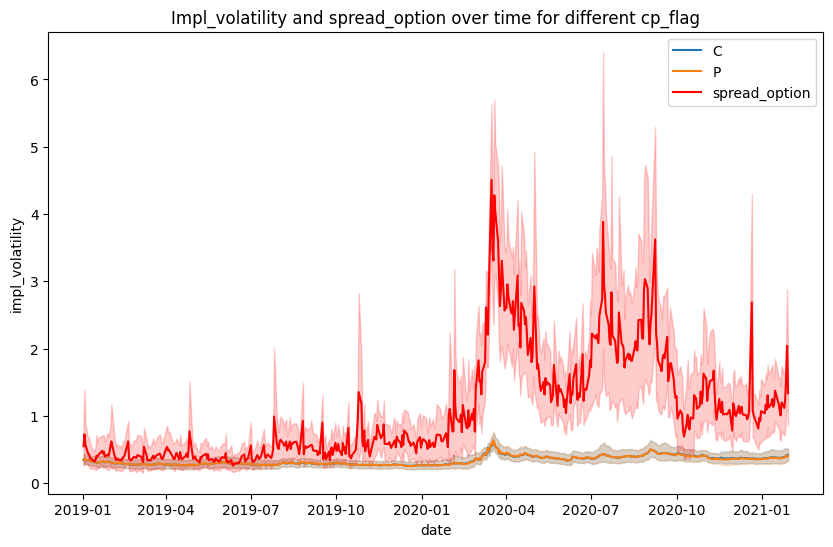

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame
mask = ((grouped_df.index.get_level_values('m_category') == "|m|≤0.5") & 
        (grouped_df.index.get_level_values('maturity_group') == 'τ>60'))
filtered_df = grouped_df.loc[mask]

# Create a plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='impl_volatility', hue='cp_flag', data=filtered_df)
sns.lineplot(x='date', y='spread_option', data=filtered_df, color='red', label='spread_option')
plt.title('Impl_volatility and spread_option over time for different cp_flag')
plt.show()

In [229]:
from collections import Counter

# Count the occurrences of each column name
column_counts = Counter(total_merge_df.columns)

# Get column names that occur more than once
duplicate_columns = [column for column, count in column_counts.items() if count > 1]

print(duplicate_columns)

[]


In [230]:
# Saving file 
data_set = Path.cwd().parent.parent / "Data/total_dataset_new.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set):
    total_merge_df.to_parquet(data_set)

In [231]:
total_merge_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,0.056201,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,0.056201,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0
5,P,m<-0.5,τ≤5,AAPL,2019-01-03,0.659214,0.813854,6538.666667,4091.833333,1.000000,...,0.056201,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0
6,C,m<-0.5,τ≤5,AAPL,2019-01-04,0.373498,0.000000,265.625000,45.875000,5.000000,...,0.056201,6.0,0.028228,2.566203e-12,0.042578,0.027907,0.338390,3.354553,1.052410e-08,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,P,|m|≤0.5,τ>60,WMT,2021-01-27,0.282445,0.290402,4.500000,1145.125000,134.444444,...,0.030636,4.0,0.013418,5.011602e-12,0.012561,0.006608,0.319214,0.851810,3.388716e-08,53.0
113396,C,|m|≤0.5,τ>60,WMT,2021-01-28,0.282815,0.278202,335.916667,2676.416667,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113397,P,|m|≤0.5,τ>60,WMT,2021-01-28,0.273449,0.283645,153.777778,1471.111111,132.818182,...,0.030636,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0
113398,C,|m|≤0.5,τ>60,WMT,2021-01-29,0.299363,0.294052,296.909091,3112.636364,134.166667,...,0.030636,4.0,0.013090,4.583290e-12,0.011986,0.006240,0.316528,0.844210,3.306939e-08,53.0


In [232]:
# Check for NaN values column-wise
nan_columns = total_merge_df.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
cp_flag           0
m_category        0
maturity_group    0
Ticker            0
date              0
                 ..
retvol            0
std_dolvol        0
std_turn          0
zerotrade         0
sic2              0
Length: 122, dtype: int64
Columns with NaN values:
[]


# Create labels for the 2 different sectors

In [233]:
tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]
retail_sector = [ "WMT", "COST", "HD",]

#add a new column sector
total_merge_df['sector'] = np.where(total_merge_df['Ticker'].isin(tech_sector), 'Tech', 'Retail')


# firm_permno = [10107, 84788, 86580, 13407, 93436, 55976, 87055, 86783, 90808, 24476, 66181, 14593]
total_merge_df

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_73797/2687433268.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,sector
2,C,m<-0.5,τ≤5,AAPL,2019-01-02,0.517976,0.388720,4965.000000,9246.000000,2.000000,...,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0,Tech
3,P,m<-0.5,τ≤5,AAPL,2019-01-02,0.506737,0.345317,4814.428571,2574.428571,2.000000,...,6.0,0.027847,2.548018e-12,0.040515,0.027893,0.344719,3.369334,1.040351e-08,36.0,Tech
4,C,m<-0.5,τ≤5,AAPL,2019-01-03,0.774712,0.472727,2924.000000,2819.750000,1.000000,...,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0,Tech
5,P,m<-0.5,τ≤5,AAPL,2019-01-03,0.659214,0.813854,6538.666667,4091.833333,1.000000,...,6.0,0.028037,2.557111e-12,0.041546,0.027900,0.341555,3.361944,1.046380e-08,36.0,Tech
6,C,m<-0.5,τ≤5,AAPL,2019-01-04,0.373498,0.000000,265.625000,45.875000,5.000000,...,6.0,0.028228,2.566203e-12,0.042578,0.027907,0.338390,3.354553,1.052410e-08,36.0,Tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,P,|m|≤0.5,τ>60,WMT,2021-01-27,0.282445,0.290402,4.500000,1145.125000,134.444444,...,4.0,0.013418,5.011602e-12,0.012561,0.006608,0.319214,0.851810,3.388716e-08,53.0,Retail
113396,C,|m|≤0.5,τ>60,WMT,2021-01-28,0.282815,0.278202,335.916667,2676.416667,132.818182,...,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0,Retail
113397,P,|m|≤0.5,τ>60,WMT,2021-01-28,0.273449,0.283645,153.777778,1471.111111,132.818182,...,4.0,0.013254,4.797446e-12,0.012274,0.006424,0.317871,0.848010,3.347828e-08,53.0,Retail
113398,C,|m|≤0.5,τ>60,WMT,2021-01-29,0.299363,0.294052,296.909091,3112.636364,134.166667,...,4.0,0.013090,4.583290e-12,0.011986,0.006240,0.316528,0.844210,3.306939e-08,53.0,Retail


# Create 2 data sets 1 for tech and 1 for retail

In [236]:
dataset_tech = total_merge_df[total_merge_df['sector'] == "Tech"]
dataset_retail = total_merge_df[total_merge_df['sector'] == "Retail"]

# Remove the 'sector' column
dataset_tech = dataset_tech.drop('sector', axis=1)
dataset_retail = dataset_retail.drop('sector', axis=1)

# Saving file 
data_set_tech = Path.cwd().parent.parent / "Data/total_dataset_tech.parquet"
data_set_retail = Path.cwd().parent.parent / "Data/total_dataset_retail.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_tech):
    dataset_tech.to_parquet(data_set_tech)

save_parquet = True
if save_parquet or not os.path.exists(data_set_retail):
    dataset_retail.to_parquet(data_set_retail)